In [1]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD, SVDpp, accuracy
from surprise import KNNBasic
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

In [220]:
df_users = pd.read_csv('users_restaurants_illinois_reduced.csv')
df_business = pd.read_csv('businesses_restaurants_illinois_reduced.csv')
df_ratings = pd.read_csv('ratings_restaurants_illinois_reduced.csv')
df_users = df_users.drop(columns=['Unnamed: 0'])
df_business = df_business.drop(columns=['Unnamed: 0'])
df_ratings = df_ratings.drop(columns=['Unnamed: 0'])

In [221]:
df_ratings_cop = df_ratings.copy()
df_ratings_cop = df_ratings_cop.groupby(['user_id'])['date'].max()
df_ratings_cop = df_ratings_cop.to_frame()
df_ratings_cop = df_ratings_cop.reset_index()

In [222]:
df_ratings['index']=df_ratings.index

In [223]:
df_ratings_test = pd.merge(df_ratings, df_ratings_cop, how='right')
df_ratings_test = df_ratings_test.drop([2327,2328])
df_ratings_test = df_ratings_test.reset_index(drop=True)

In [224]:
df_ratings_train = df_ratings.drop(list(df_ratings_test['index']))

In [225]:
df_ratings_train = df_ratings_train.drop(columns=['date','index'])
df_ratings_test = df_ratings_test.drop(columns=['date','index'])
df_ratings_train = df_ratings_train.reset_index(drop=True)
df_ratings_test = df_ratings_test.reset_index(drop=True)

# Reference measure: Average Rating

We evaluate the RMSE and MAE when we predict the average rating of the train set for the entire test set. It's a reference measure.

In [39]:
average_train = df_ratings_train.rating.mean()
pred_average = np.repeat(average_train, df_ratings_test.shape[0])

In [40]:
mean_squared_error(df_ratings_test['rating'], pred_average)

1.9393005832255554

In [157]:
np.sqrt(mean_squared_error(df_ratings_test['rating'], pred_average))

1.3925877290948514

In [41]:
mean_absolute_error(df_ratings_test['rating'], pred_average)

1.2065156420765029

# Graphs Construction

In [42]:
import networkx as nx

## Users Graph

In [43]:
df_users_graph = df_users[['user_id','friends']]

In [44]:
users = []
for i in range(df_users_graph.shape[0]):
    friends = df_users_graph['friends'][i].split(', ')
    users.append([df_users_graph['user_id'][i], friends])

In [45]:
G_users = nx.Graph()

for i in range(len(users)):
    G_users.add_node(users[i][0])

nl = list(G_users.nodes())
for i in range(len(users)):
    user = users[i][0]
    friends = users[i][1]
    for friend in friends:
        if friend in nl:
            G_users.add_edge(user, friend)


## User-Restaurant Bipartite Graph

In [46]:
users_list = df_users['user_id'].tolist()
restaurants_list = df_business['business_id'].tolist()

links_list = []
for i in range(df_ratings_train.shape[0]):
    links_list.append((df_ratings_train['user_id'][i], df_ratings_train['business_id'][i], df_ratings_train['rating'][i]))
    
    

In [47]:
G_us_re = nx.Graph()

G_us_re.add_nodes_from(users_list, bipartite=0)
G_us_re.add_nodes_from(restaurants_list, bipartite=1)

G_us_re.add_weighted_edges_from(links_list)

In [49]:
if nx.is_connected(G_us_re):
    restaurants_nodes, users_nodes = nx.bipartite.sets(G_us_re)
else:
    users_nodes = {n for n, d in G_us_re.nodes(data=True) if d['bipartite']==0}
    restaurants_nodes = set(G_us_re) - users_nodes

# Recommendations

## Rating prediction based on User-Restaurant Bipartite Graph

The library Surprise allow to build recommendation systems thanks to collaborative filtering, but it does not support large datasets and leads to kernel crashes. We implemented the methods by our own.

In [50]:
def similarity(u,v,other_nodes, G):
    p, a, b = 0, 0, 0
    for i in other_nodes:
        p += G.get_edge_data(u,i,default={'weight': 0.0})['weight']*G.get_edge_data(v,i,default={'weight': 0.0})['weight']
        a += G.get_edge_data(u,i,default={'weight': 0.0})['weight']**2
        b += G.get_edge_data(v,i,default={'weight': 0.0})['weight']**2
    sim = p/(np.sqrt(a)*np.sqrt(b))
    return sim    

### User Collaborative Filtering

We compute cosine similarities among users.

In [51]:
ar_similarities_user = np.zeros((len(users_list), len(users_list)))
for u in range(len(users_list)):
    for v in range(u, len(users_list)):
        ar_similarities_user[u][v] = similarity(users_list[u],users_list[v],restaurants_nodes,G_us_re)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [52]:
ar_similarities_user_f = ar_similarities_user + ar_similarities_user.transpose() - np.eye(len(users_list))
df_similarities_user = pd.DataFrame(ar_similarities_user_f, columns = users_list, index = users_list)

Remark: Some NaN because some users have never published a Rating before the train/test separation date

In [53]:
df_similarities_user_na = df_similarities_user.fillna(0.0)

In [64]:
df_similarities_user.to_csv('similarities_bipartite_users_withnan_bis.csv')

In [65]:
df_similarities_user_na.to_csv('similarities_bipartite_users_bis.csv')

In [56]:
def prediction_userCF(df_similarities,u,i):
    '''
    Returns the predicted rating by user u for restaurant i
    
    Arguments:
        similarities: similarities between users
        u: a user
        i: a restaurant
    '''
    n,d = 0,0
    pred = 0
    for v in users_nodes:
        rating_v_i = G_us_re.get_edge_data(v,i,default={'weight': 0.0})['weight']
        if rating_v_i != 0:
            n += df_similarities[u][v]*rating_v_i
            d += df_similarities[u][v]
    if d !=0:
        pred = n/d
    else:
        pred = average_train
    return pred
    

In [57]:
def make_pred_userCF(df_ratings_test,df_similarities):
    pred = []
    for j in range(df_ratings_test.shape[0]):
        userid = df_ratings_test['user_id'][j]
        businessid = df_ratings_test['business_id'][j]
        pred.append(prediction_userCF(df_similarities,userid,businessid))
    return pred

In [58]:
pred_userCF = make_pred_userCF(df_ratings_test,df_similarities_user_na)

In [59]:
#np.sum(df_similarities_user_na.loc[df_similarities_user_na.index == '4mjnkd8oJVCfBKN3i4rB-g'].values)

In [60]:
mean_squared_error(df_ratings_test['rating'], pred_userCF)

1.873694307714286

In [61]:
mean_absolute_error(df_ratings_test['rating'], pred_userCF)

1.0962555588837808

In [62]:
nb_changed_values = df_ratings_test.shape[0]-pred_userCF.count(average_train)
nb_changed_values

2723

### Item Collaborative Filtering

In [66]:
ar_similarities_rest = np.zeros((len(restaurants_list), len(restaurants_list)))
for u in range(len(restaurants_list)):
    for v in range(u, len(restaurants_list)):
        ar_similarities_rest[u][v] = similarity(restaurants_list[u],restaurants_list[v],users_nodes,G_us_re)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [67]:
ar_similarities_rest_f = ar_similarities_rest + ar_similarities_rest.transpose() - np.eye(len(restaurants_list))
df_similarities_rest = pd.DataFrame(ar_similarities_rest_f, columns = restaurants_list, index = restaurants_list)

In [68]:
df_similarities_rest_na = df_similarities_rest.fillna(0.0)

In [69]:
df_similarities_rest.to_csv('similarities_bipartite_rest_withnan_bis.csv')

In [70]:
df_similarities_rest_na.to_csv('similarities_bipartite_rest_bis.csv')

In [71]:
def prediction_itemCF(df_similarities,u,i):
    '''
    Returns the predicted rating by user u for restaurant i
    
    Arguments:
        similarities: similarities between users
        u: a user
        i: a restaurant
    '''
    n,d = 0,0
    pred = 0
    for j in restaurants_nodes:
        rating_u_j = G_us_re.get_edge_data(u,j,default={'weight': 0.0})['weight']
        if rating_u_j != 0:
            n += df_similarities[i][j]*rating_u_j
            d += df_similarities[i][j]
    if d != 0:
        pred = n/d
    else:
        pred = average_train
    return pred


In [72]:
def make_pred_itemCF(df_ratings_test,df_similarities):
    pred = []
    for j in range(df_ratings_test.shape[0]):
        userid = df_ratings_test['user_id'][j]
        businessid = df_ratings_test['business_id'][j]
        pred.append(prediction_itemCF(df_similarities,userid,businessid))
    return pred

In [73]:
pred_itemCF = make_pred_itemCF(df_ratings_test,df_similarities_rest_na)

In [74]:
mean_squared_error(df_ratings_test['rating'], pred_itemCF)

2.220415561943532

In [75]:
mean_absolute_error(df_ratings_test['rating'], pred_itemCF)

1.1288097657832012

In [76]:
nb_changed_values = df_ratings_test.shape[0]-pred_itemCF.count(average_train)
nb_changed_values

2723

### Latent Collaborative Filtering: SVD

In [77]:
reader = Reader(rating_scale = (0.0, 5.0))

train_data = Dataset.load_from_df(df_ratings_train[['user_id', 'business_id', 'rating']], reader)
test_data = Dataset.load_from_df(df_ratings_test[['user_id', 'business_id', 'rating']], reader)

sr_train = train_data.build_full_trainset()
sr_test_before = test_data.build_full_trainset()
sr_test = sr_test_before.build_testset()


In [78]:
algo_latent = SVD()
algo_latent.fit(sr_train)

In [79]:
pred_latent = algo_latent.test(sr_test)

In [80]:
accuracy.mse(pred_latent)

MSE: 1.5960


1.5959517846195412

In [81]:
accuracy.mae(pred_latent)

MAE:  1.0409


1.040877588931486

In [82]:
pred_latent_list = [pred_latent[i][3] for i in range(len(pred_latent))]

In [83]:
nb_changed_values = df_ratings_test.shape[0]-pred_latent_list.count(average_train)
nb_changed_values

3000

### SVD++

In [84]:
algo_latent2 = SVDpp()
algo_latent2.fit(sr_train)

In [85]:
pred_latent2 = algo_latent2.test(sr_test)

In [86]:
accuracy.mse(pred_latent2)

MSE: 1.5748


1.5747960043659566

In [87]:
accuracy.mae(pred_latent2)

MAE:  1.0279


1.0278570789684343

In [153]:
pred_latent2_list = [pred_latent2[i][3] for i in range(len(pred_latent2))]

### Deep Matrix Factorization

In [195]:
from tqdm import tqdm
import json
import time
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [196]:
class Model(nn.Module):
    def __init__(self,  N_business, N_user, N, user_dim, business_dim, n_layers = 2, dropout = 0.5):
        super(Model, self).__init__()
        self.N = N
        self.n_layers = n_layers
        self.dropout = dropout

        self.left_1 = nn.Linear(user_dim, N_user)
        self.left_2 = nn.Linear(N_user, N)
        self.right_1 = nn.Linear(business_dim, N_business)
        self.right_2 = nn.Linear(N_business, N)
        self.cosine = nn.CosineSimilarity(dim=1, eps=1e-6)


    def forward(self, user, business):

        user_tensor = F.relu(self.right_1(user))
        user_tensor = F.relu(self.right_2(user_tensor))
        business_tensor = F.relu(self.left_1(business))
        business_tensor = F.relu(self.left_2(business_tensor))
        cosine = self.cosine(user_tensor, business_tensor)

        return cosine

def train(data_loader, validation_loader, model, criterion, optimizer, epochs):

    print("There are {} batches".format(len(data_loader)))
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        print("epoch {}".format(epoch + 1))
        for i, batch in enumerate(data_loader):
            # get the inputs; data is a list of [inputs, labels]
            user, label, business = tuple(batch.values())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(user.float(), business.float())


            loss = criterion(outputs*5, label.float())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print("     mean loss : {}".format(running_loss/len(dataloader)))

        AE, SE = evaluate_validation(model, validation_loader)

        print("     On Validation, MSE is {}".format(SE))
        print("     On Validation, MAE is {}".format(AE))
    print('Finished Training')

def my_loss(output, labels):
    output_clipped = torch.max(output, torch.tensor(1e-6).float())
    a = -(torch.log(output_clipped) * labels / 5 + torch.log(1 - output_clipped) * (1 - labels/5))
    return torch.sum(a)

def evaluate_validation(model, validation_loader):
    AE = 0
    SE = 0
    with torch.no_grad():
        MSE = nn.MSELoss()
        MAE = nn.L1Loss()
        count = 0
        for sample in validation_loader:
            count += 1
            user, label, business = tuple(sample.values())
            output = model(user, business)
            AE += MAE(torch.round(5 * output), label)
            SE += MSE(torch.round(5 * output), label)

    return AE/count, SE/count


class Set(Dataset):
    """Training Set."""

    def __init__(self, y, set, transform=None):
        """
        Args:

        """
        self.y = y
        self.set = set
        self.transform = transform
    def __len__(self):
        return len(self.set)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        i, j, label = self.set[idx]
        user = torch.tensor(y[i,:]).float()
        business = torch.tensor(y[:, j]).float()
        label = torch.tensor(label).float()

        sample = {"user": user, "label": label, "business": business}


        if self.transform:
            sample = self.transform(sample)

        return sample

In [197]:
np.random.seed(1)
torch.manual_seed(1)

id2usr = dict(df_users.user_id)
id2bus = dict(df_business.business_id)
bus2id = {v: k for k, v in id2bus.items()}
usr2id = {v: k for k, v in id2usr.items()}

y = np.zeros((len(id2usr), len(id2bus)))
trainset = []
for index, row in df_ratings_train.iterrows():
    i = usr2id[row['user_id']]
    j = bus2id[row['business_id']]
    y[i,j] = row['rating']
    trainset.append((i, j, y[i,j]))


Dataset_train = Set(y, trainset)

dataloader = DataLoader(Dataset_train, batch_size=256, num_workers=4, shuffle = True)

user_dim, business_dim = y.shape
N = 64
N_business = 1024
N_user = 512
n_layers = 2
model = Model(N_business, N_user, N, user_dim, business_dim, n_layers = 2, dropout = 0.5)

optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())

# criterion = nn.BCELoss()

criterion = nn.MSELoss()

test_set = []

for index, row in df_ratings_test.iterrows():
    i = usr2id[row['user_id']]
    j = bus2id[row['business_id']]
    y[i,j] = row['rating']
    test_set.append((i, j, y[i,j]))

del df_ratings_test

validation_dataset = Set(y, test_set)
validation_dataloader = DataLoader(validation_dataset, batch_size=1)

train(dataloader, validation_dataloader, model, criterion = criterion, optimizer = optimizer, epochs=20)

There are 77 batches
epoch 1
     mean loss : 1.494959998440433
     On Validation, MSE is 1.5720000267028809
     On Validation, MAE is 0.9906666874885559
epoch 2
     mean loss : 1.1326492297184931
     On Validation, MSE is 1.4593333005905151
     On Validation, MAE is 0.9353333115577698
epoch 3
     mean loss : 0.876978981804538
     On Validation, MSE is 1.3303333520889282
     On Validation, MAE is 0.8816666603088379
epoch 4
     mean loss : 0.6589512646972359
     On Validation, MSE is 1.3233333826065063
     On Validation, MAE is 0.8799999952316284
epoch 5
     mean loss : 0.5365470953575977
     On Validation, MSE is 1.3580000400543213
     On Validation, MAE is 0.8999999761581421
epoch 6
     mean loss : 0.47121583873575384
     On Validation, MSE is 1.3519999980926514
     On Validation, MAE is 0.8986666798591614
epoch 7
     mean loss : 0.4382628275976553
     On Validation, MSE is 1.3803333044052124
     On Validation, MAE is 0.9076666831970215
epoch 8
     mean loss : 0.4

### Graph Projection Method: Network Based Inference

In [204]:
from sklearn.base import BaseEstimator, ClassifierMixin
from networkx.algorithms import bipartite as bip

In [199]:
# We did not code this class
# You can find it on Github
# https://github.com/ijcruic/NetworkBasedInference

class NBI(BaseEstimator, ClassifierMixin):
    
    def __init__(self):
        pass

    def fit(self, A):
        '''
        A is a bipartite network of two not neccesarily equal dimensions and a numpy 
        array of binary data
        '''
        A = A.astype(dtype=float)
        A = np.asanyarray(A)
        k_x = np.sum(A, axis=0)
        k_y = np.sum(A, axis=1)
        W = np.zeros((A.shape[1], A.shape[1]))
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W[i,j] = np.divide(1, k_x[j], out=np.zeros_like(k_x[j]), where=k_x[j]!=0)*np.sum(np.divide(np.multiply(A[:,i],A[:,j]), k_y))
        self.W_ = W
        
        return self
    
    def predict(self, a):
        
        a = np.asanyarray(a)
        f_prime = np.zeros(a.shape[0])
        
        for j in range(f_prime.shape[0]):
            f_prime[j] = np.sum(np.multiply(self.W_[j,:], a))
        
        self.y_ = f_prime
        return self.y_

#### Exemple on toy graph

In [200]:
toy = nx.Graph()

In [201]:
toy.add_nodes_from(['u1', 'u2', 'u3'], bipartite=0)
toy.add_nodes_from(['o1', 'o2', 'o3', 'o4'], bipartite=1)

In [202]:
toy.add_edges_from([('u1', 'o1'), ('u1', 'o2'), ('u1', 'o4')])
toy.add_edges_from([('u2', 'o2'), ('u2', 'o3')])
toy.add_edges_from([('u3', 'o2'), ('u3', 'o3'), ('u3', 'o4')])

In [205]:
top_nodes, bottom_nodes = bip.sets(toy)

In [206]:
layout = {'o1': np.array([-3, -1]),
          'o2': np.array([-1, -1]),
          'o3': np.array([1, -1]),
          'o4': np.array([3, -1]),
          'u1': np.array([-2, .5]),
          'u2': np.array([0, .5]),
          'u3': np.array([2, .5])}

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


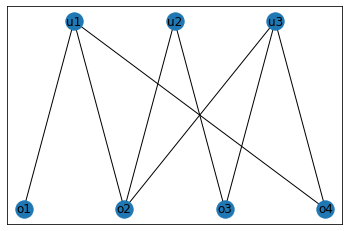

In [207]:
nx.drawing.nx_pylab.draw_networkx(toy, pos=layout)

In [208]:
A = nx.adjacency_matrix(toy, nodelist=['u1','u2','u3','o1','o2','o3','o4']).toarray()
A

array([[0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0]], dtype=int64)

In [209]:
est = NBI()

In [210]:
est.fit(A).W_

array([[0.61111111, 0.16666667, 0.27777778, 0.        , 0.        ,
        0.        , 0.        ],
       [0.11111111, 0.41666667, 0.27777778, 0.        , 0.        ,
        0.        , 0.        ],
       [0.27777778, 0.41666667, 0.44444444, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.11111111,
        0.        , 0.16666667],
       [0.        , 0.        , 0.        , 0.33333333, 0.38888889,
        0.41666667, 0.33333333],
       [0.        , 0.        , 0.        , 0.        , 0.27777778,
        0.41666667, 0.16666667],
       [0.        , 0.        , 0.        , 0.33333333, 0.22222222,
        0.16666667, 0.33333333]])

In [211]:
W = est.fit(A).W_[3:,3:]
W

array([[0.33333333, 0.11111111, 0.        , 0.16666667],
       [0.33333333, 0.38888889, 0.41666667, 0.33333333],
       [0.        , 0.27777778, 0.41666667, 0.16666667],
       [0.33333333, 0.22222222, 0.16666667, 0.33333333]])

In [212]:
mat = np.array([[11/18, 1/6, 5/18],
                 [1/9, 5/12, 5/18],
                 [5/18, 5/12, 4/9]])
mat

array([[0.61111111, 0.16666667, 0.27777778],
       [0.11111111, 0.41666667, 0.27777778],
       [0.27777778, 0.41666667, 0.44444444]])

#### On our bipartite graph

 We remove users and restaurants without rating.

In [213]:
B = nx.adjacency_matrix(G_us_re, nodelist=list(G_us_re.nodes())).toarray()

In [214]:
s = 0
empty_users = []
for i in range(3000):
  if sum(B[i,])==0:
    # G_us_re.remove_node(users_list[i])
    empty_users.append(users_list[i])
    s += 1

t = 0
empty_restaurants = []
for i in range(838):
  if sum(B[i+3000,])==0:
    # G_us_re.remove_node(restaurants_list[i])
    empty_restaurants.append(restaurants_list[i])
    t += 1

users_list_ = list(set(users_list) - set(empty_users))
restaurants_list_ = list(set(restaurants_list) - set(empty_restaurants))

In [226]:
df_ratings_test_ = df_ratings_test[ df_ratings_test['user_id'].isin(users_list_) ]
df_ratings_test__ = df_ratings_test_[ df_ratings_test['business_id'].isin(restaurants_list_) ]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [227]:
links_list = []
for i in range(df_ratings_train.shape[0]):
    links_list.append((df_ratings_train['user_id'][i], df_ratings_train['business_id'][i], 1))

G_us_re_ = nx.Graph()

G_us_re_.add_nodes_from(users_list_, bipartite=0)
G_us_re_.add_nodes_from(restaurants_list_, bipartite=1)

G_us_re_.add_weighted_edges_from(links_list)

if nx.is_connected(G_us_re_):
    restaurants_nodes, users_nodes = nx.bipartite.sets(G_us_re_)
else:
    users_nodes = {n for n, d in G_us_re_.nodes(data=True) if d['bipartite']==0}
    restaurants_nodes = set(G_us_re_) - users_nodes_

G_us_re_edges = G_us_re.edges()
G_us_re_edges_w = G_us_re.edges.data('weight', default=0)

In [228]:
def initial_resource(k):
  '''
  Returns the initial rating vector of the k-th user
  '''
  # n_restos = len(restaurants_list)-11
  n_restos = len(restaurants_list_)
  f_0 = np.zeros((n_restos, 1))
  
  user_id = users_list_[k]
  restos_ids = df_ratings_train[df_ratings_train['user_id']==user_id]['business_id'].values
  ratings = df_ratings_train[df_ratings_train['user_id']==user_id]['rating'].values
  
  for i in range(len(restos_ids)):
    resto_idx = restaurants_list_.index(restos_ids[i])
    if ratings[i] > 2:
      f_0[resto_idx] = 1
    else:
      f_0[resto_idx] = 0
  
  return f_0

In [229]:
C = nx.adjacency_matrix(G_us_re_, nodelist=list(G_us_re_.nodes())).toarray()
C.shape

(3695, 3695)

In [230]:
estimator = NBI()

In [231]:
complete_W_ = estimator.fit(C).W_

In [232]:
W_ = complete_W_[2868:,2868:]
np.savetxt('U matrix', W_, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)

In [233]:
W_

array([[0.06753264, 0.00035842, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00046751, 0.13089334, 0.01282051, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00128205, 0.0576481 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.04895833, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.21537037,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09384318]])

In [234]:
def recommended_restos(W_f):
  n = W_f.shape[0]
  liste = [W_f[i,0] for i in range(n)]
  sorted_idx = np.flip(np.argsort(liste))
  selected_idx = sorted_idx[:int(0.6*n)]

  selected_restos = []
  for i in selected_idx:
    selected_restos.append(restaurants_list_[i])
  return selected_restos

In [235]:
accuracy = 0
longueur = 0

for i in range(len(df_ratings_test__)):
  user = df_ratings_test__.iloc[i]['user_id']
  user_idx = users_list_.index(user)
  restaurant = df_ratings_test__.iloc[i]['business_id']
  rating = df_ratings_test__.iloc[i]['rating']

  W_f = W_.dot(initial_resource(user_idx))
  recommended = recommended_restos(W_f)

  if (rating > 2) and (restaurant in recommended):
    accuracy += 1

accuracy = accuracy/len(df_ratings_test__)
print("accuracy on test set =", 100*accuracy, "%")

accuracy on test set = 70.7659873506676 %


## Rating prediction based on User-User Graph

#### Jaccard similarity

In [88]:
df_similarities_user_uni = pd.DataFrame(columns = users_list, index = users_list)
for u in users_list:
    for v in users_list:
        jac = nx.jaccard_coefficient(G_users, [(u,v)])
        for a,b,c in jac:
            df_similarities_user_uni[u][v] = c

In [89]:
for u in users_list:
    df_similarities_user_uni[u][u] = 1.0

In [90]:
df_similarities_user_uni.to_csv('similarities_unipartite_jaccard_users_bis.csv')

In [91]:
pred_useruser = make_pred_userCF(df_ratings_test,df_similarities_user_uni)


In [92]:
mean_squared_error(df_ratings_test['rating'], pred_useruser)

1.9932756406260481

In [93]:
mean_absolute_error(df_ratings_test['rating'], pred_useruser)

1.1869644644833475

In [94]:
nb_changed_values = df_ratings_test.shape[0]-pred_useruser.count(average_train)
nb_changed_values

629

#### Other similarity measure: FriendTNS

In [95]:
def friendTNS(G_users,u,v):
    sim = 0
    edges = [e for e in G_users.edges()]
    if (u,v) in edges or (v,u) in edges:
        sim = 1/(G_users.degree(u)+G_users.degree(v)-1)
    else:
        sim = 0
    return sim 

In [96]:
ar_similarities_user_uniTNS = np.zeros((len(users_list), len(users_list)))
for u in range(len(users_list)):
    for v in range(u, len(users_list)):
        ar_similarities_user_uniTNS[u][v] = friendTNS(G_users, users_list[u], users_list[v])

In [97]:
ar_similarities_user_uniTNS_f = ar_similarities_user_uniTNS + ar_similarities_user_uniTNS.transpose() - np.eye(len(users_list))
df_similarities_user_uniTNS = pd.DataFrame(ar_similarities_user_uniTNS_f, columns = users_list, index = users_list)

In [98]:
for u in users_list:
    df_similarities_user_uniTNS[u][u] = 1.0

In [99]:
df_similarities_user_uniTNS.to_csv('similarities_unipartite_TNS_users_bis.csv')

In [100]:
pred_useruserTNS = make_pred_userCF(df_ratings_test,df_similarities_user_uniTNS)

In [101]:
mean_squared_error(df_ratings_test['rating'], pred_useruserTNS)

1.9713999069857184

In [102]:
mean_absolute_error(df_ratings_test['rating'], pred_useruserTNS)

1.1936409528162337

In [103]:
nb_changed_values = df_ratings_test.shape[0]-pred_useruserTNS.count(average_train)
nb_changed_values

267

Remark:

In [104]:
len([a for a in nx.isolates(G_users)])

1812

We have 1812 users without any friend. That's why the prediction using the unipartite graph is not really performant.

## Rating prediction based on Multi Graph

We will use our different similarity matrices in order to develop a better recommendation system based on our two users similarity matrices.

In [105]:
from sklearn.preprocessing import MinMaxScaler

In [106]:
df_1 = pd.read_csv('similarities_bipartite_users_bis.csv')
df_2 = pd.read_csv('similarities_unipartite_TNS_users_bis.csv')
df_1 = df_1.set_index('Unnamed: 0')
df_2 = df_2.set_index('Unnamed: 0')

In [107]:
#Normalization of our similarity matrices
ar_1 = df_1.values
std1 = ar_1.std(ddof=1)
mean1 = ar_1.mean()
ar_1 = (ar_1-mean1)/std1
df_sim_1 = pd.DataFrame(ar_1, columns = users_list, index = users_list)

scaler = MinMaxScaler()
df_sim_1_sc = pd.DataFrame(scaler.fit_transform(df_sim_1), columns=df_sim_1.columns, index=df_sim_1.index)


In [108]:
ar_2 = df_2.values
std2 = ar_2.std(ddof=1)
mean2 = ar_2.mean()
ar_2 = (ar_2-mean2)/std2
df_sim_2 = pd.DataFrame(ar_2, columns = users_list, index = users_list)

scaler = MinMaxScaler()
df_sim_2_sc = pd.DataFrame(scaler.fit_transform(df_sim_2), columns=df_sim_2.columns, index=df_sim_2.index)


In [109]:
def rating_u_i(u,i,G_us_re,G_users,df_sim_1_sc,df_sim_2_sc,average_train):
    A = (G_users.degree(u)*G_users.number_of_nodes())/nx.adjacency_matrix(G_users).count_nonzero()
    R = (G_us_re.degree(u)*G_users.number_of_nodes())/G_us_re.number_of_edges()
    if A+R !=0:
        r = R/(A+R)
    else:
        r=1/2
    similarities_1 = np.asarray(df_sim_1_sc[u])
    similarities_2 = np.asarray(df_sim_2_sc[u])
    ar_sim = r*similarities_1 + (1-r)*similarities_2
    
    n,d = 0,0
    pred = 0
    for v in users_list:
        index_v = users_list.index(v)
        rating_v_i = G_us_re.get_edge_data(v,i,default={'weight': 0.0})['weight']
        if rating_v_i != 0:
            n += ar_sim[index_v]*rating_v_i
            d += ar_sim[index_v]
    if d !=0:
        pred = n/d
    else:
        pred = average_train
    return pred
    

In [110]:
def rating_predictions(df_ratings_test,G_us_re,G_users,df_sim_1_sc,df_sim_2_sc,average_train):
    pred = []
    for z in range(df_ratings_test.shape[0]):
        userid = df_ratings_test['user_id'][z]
        businessid = df_ratings_test['business_id'][z]
        pred.append(rating_u_i(userid,businessid,G_us_re,G_users,df_sim_1_sc,df_sim_2_sc,average_train))
    return pred

In [111]:
pred_multi = rating_predictions(df_ratings_test,G_us_re,G_users,df_sim_1_sc,df_sim_2_sc,average_train)


In [112]:
mean_squared_error(df_ratings_test['rating'], pred_multi)

1.8698799201133873

In [113]:
mean_absolute_error(df_ratings_test['rating'], pred_multi)

1.0943437483232776

In [114]:
nb_changed_values = df_ratings_test.shape[0]-pred_multi.count(average_train)
nb_changed_values

2727

In [115]:
df_ratings_test_pred = df_ratings_test[['user_id','business_id','rating']]
df_ratings_test_pred['predicted'] = pred_multi

In [132]:
df_ratings_test_pred.head()

,user_id,business_id,rating,predicted
0,6X0i-oGUbh5DZdTHzFuKfg,dHkbBWmXXjaO_-9BgQyEPg,1.0,2.568443
1,TPFWtsUi_GwNm6BX6vGv5g,F1qPjasn0R6-j8sa6iYNmA,4.0,2.940811
2,-o-EaM-C3PROpIcwtI_AFw,QxbVPV2xndVP-nT1IRKF1w,2.0,4.000000
3,CHkneOHkRH9Yf-LY-XlTIg,eJtmOfqwGj5sYKQrB01oWQ,1.0,3.204360
4,oJl-C8UECsibhHS2dB8yzQ,PBmfdx-tC2D54FI3HtcKww,2.0,3.224926


In [141]:
df_ratings_test_pred_x = df_ratings_test_pred.copy()
df_ratings_test_pred_x['pred_round']= round(df_ratings_test_pred_x['predicted'])


In [143]:
mean_squared_error(df_ratings_test_pred_x['rating'], df_ratings_test_pred_x['pred_round'])

1.9683333333333333

In [144]:
mean_absolute_error(df_ratings_test_pred_x['rating'], df_ratings_test_pred_x['pred_round'])

1.0736666666666668

In [142]:
df_ratings_test_pred_x.loc[df_ratings_test_pred_x['pred_round']==df_ratings_test_pred_x['rating']]

,user_id,business_id,rating,predicted,pred_round
6,ZgWVyPXX6bpmLDV1xvOl-w,kNtToQSP_Y5U8tznLXuCaw,4.0,4.007034,4.0
7,D-Yf58g7ZqYucgja1TUdVQ,9A1C1f0m4nQltQrOOTl-Kw,3.0,3.000000,3.0
9,iQt3ya8qaVJ347rJi5jSmA,i_t8WTwztuHweRqQ89hmuQ,4.0,3.614830,4.0
12,Yk3-qONLlCxzxc5bS-ImSQ,6ockUmdOBYBApEsUCJkBzA,5.0,4.779984,5.0
15,DPldvSGto59lJadlRxpmrw,9A1C1f0m4nQltQrOOTl-Kw,4.0,3.539027,4.0
...,...,...,...,...,...
2965,aQ1ztNVjHnGFKKnVSATkTQ,rXIDrS8Rz8r09vH4gjHfGQ,4.0,4.320066,4.0
2970,ZdzoROWb3lpr4qNOAoxtzw,0tU2xdfTSfz-BwD4VhtVAQ,4.0,3.624949,4.0
2980,dV4wf3PTE70HdaANCfcoZA,joCHRYAw1a5m-1ZhJ7uAGQ,5.0,4.626765,5.0
2988,_J5b7ykbzdxa5tmuhb74gQ,zp3rZNu-5qonTL3ByPYOUg,4.0,3.624949,4.0


In [138]:
df_ratings_test_pred_x.loc[(df_ratings_test_pred_x['pred_round']==df_ratings_test_pred_x['rating']-1)]

,user_id,business_id,rating,predicted,pred_round
1,TPFWtsUi_GwNm6BX6vGv5g,F1qPjasn0R6-j8sa6iYNmA,4.0,2.940811,3.0
5,JbRnDXp6ylbCw3jURKcB3g,hvPPw19VdGRsOEkxgyD7tg,5.0,4.251669,4.0
14,Rdp3C5KacNRbufVLL_XhMA,jeTfL2kCyBtmFGSrSQHqVw,5.0,4.153662,4.0
20,L_sVLn8BBDiVSNVlQOfCYg,L2c-qKZWumCmOCR-dqBLrg,5.0,4.173412,4.0
22,t9EWoO3fay-4_yJtCGdp3w,kNtToQSP_Y5U8tznLXuCaw,5.0,4.111889,4.0
...,...,...,...,...,...
2990,DMF6Gle5GC35h4lcl67x-Q,l4x5FFzfiCFrGN0S-uZbBQ,5.0,3.624949,4.0
2994,N4PnVYepGliRXeeITxN0iw,6jsuYyjUM45WAX-6SxOQgQ,5.0,3.624949,4.0
2995,1LtJ5w7YaxaN0equ3Oq6pw,dIUHCuiAlzkxfgCEOtky8w,5.0,3.624949,4.0
2996,EeOcpXst4ihchMBvNkAoUA,dIUHCuiAlzkxfgCEOtky8w,5.0,3.624949,4.0


In [139]:
df_ratings_test_pred_x.loc[(df_ratings_test_pred_x['pred_round']==df_ratings_test_pred_x['rating']+1)]

,user_id,business_id,rating,predicted,pred_round
4,oJl-C8UECsibhHS2dB8yzQ,PBmfdx-tC2D54FI3HtcKww,2.0,3.224926,3.0
8,sMEJUkjyTWQrdUaSBLR-sQ,9A1C1f0m4nQltQrOOTl-Kw,1.0,2.093914,2.0
11,oWjsGEPgt5qMymvmYoD0VQ,oWQwUw8xfQgi1nVNKgS6vA,3.0,3.793692,4.0
13,x6Fr3uJgECqvCFIe1d_sXQ,9A1C1f0m4nQltQrOOTl-Kw,2.0,3.044250,3.0
16,fwvJx2dzm3W9b5ajBYIPHw,KedpWqBphmRopwBd7trzFw,1.0,1.594412,2.0
...,...,...,...,...,...
2937,44ZwQqCtNIl79OaVn-sT7A,SUktrYdNQD8k2vvkM4OpfA,3.0,3.893496,4.0
2938,4zEBlnX60GYJceJ5fEXRtg,LvPbZ_5odnjE_oj5BNHivQ,3.0,4.247043,4.0
2949,DHiaN7x2UtHXRIcwwMqh0Q,4OABFHxKDYxJh9A2BhoRkg,4.0,5.000000,5.0
2972,utxFQ-yv3CXxc6KN1SvGJQ,ldKrUirpZZ6JDnNwOwLpvw,1.0,1.769401,2.0


In [140]:
1002+825+393

2220

## Rating prediction based on Multi Graph: Other approach

There are too many ratings that are not predicted (set to average_train).

In [117]:
average_users = []
for u in users_list:
    avg = df_ratings_train.loc[df_ratings_train['user_id']==u].rating.mean()
    if math.isnan(avg):
        average_users.append(average_train)
    else:
        average_users.append(avg)


In [118]:
def rating_u_i_imp(u,i,G_us_re,G_users,df_sim_1_sc,df_sim_2_sc,average_users):
    A = (G_users.degree(u)*G_users.number_of_nodes())/nx.adjacency_matrix(G_users).count_nonzero()
    R = (G_us_re.degree(u)*G_users.number_of_nodes())/G_us_re.number_of_edges()
    if A+R !=0:
        r = R/(A+R)
    else:
        r=1/2
    similarities_1 = np.asarray(df_sim_1_sc[u])
    similarities_2 = np.asarray(df_sim_2_sc[u])
    ar_sim = r*similarities_1 + (1-r)*similarities_2
    
    index_u = users_list.index(u)
    avg_u = average_users[index_u]
    
    n,d = 0,0
    pred = avg_u
    for v in users_list:
        index_v = users_list.index(v)
        avg_v = average_users[index_v]
        rating_v_i = G_us_re.get_edge_data(v,i,default={'weight': 0.0})['weight']
        if rating_v_i != 0:
            n += ar_sim[index_v]*abs(rating_v_i - avg_v)
            d += ar_sim[index_v]
    if d !=0:
        pred += n/d
    return pred
    

In [119]:
def rating_predictions_imp(df_ratings_test,G_us_re,G_users,df_sim_1_sc,df_sim_2_sc,average_users):
    pred = []
    for z in range(df_ratings_test.shape[0]):
        userid = df_ratings_test['user_id'][z]
        businessid = df_ratings_test['business_id'][z]
        pred.append(rating_u_i_imp(userid,businessid,G_us_re,G_users,df_sim_1_sc,df_sim_2_sc,average_users))
    return pred

In [120]:
pred_multi_imp = rating_predictions_imp(df_ratings_test,G_us_re,G_users,df_sim_1_sc,df_sim_2_sc,average_users)


In [121]:
mean_squared_error(df_ratings_test['rating'], pred_multi_imp)

2.8655603797249047

In [122]:
mean_absolute_error(df_ratings_test['rating'], pred_multi_imp)

1.2924552661184818

In [123]:
nb_changed_values = df_ratings_test.shape[0]-pred_multi_imp.count(average_train)
nb_changed_values

2871

In [124]:
df_ratings_test_pred_2 = df_ratings_test[['user_id','business_id','rating']]
df_ratings_test_pred_2['predicted'] = pred_multi_imp

In [125]:
df_ratings_test_pred_2

,user_id,business_id,rating,predicted
0,6X0i-oGUbh5DZdTHzFuKfg,dHkbBWmXXjaO_-9BgQyEPg,1.0,3.971954
1,TPFWtsUi_GwNm6BX6vGv5g,F1qPjasn0R6-j8sa6iYNmA,4.0,3.404085
2,-o-EaM-C3PROpIcwtI_AFw,QxbVPV2xndVP-nT1IRKF1w,2.0,3.502398
3,CHkneOHkRH9Yf-LY-XlTIg,eJtmOfqwGj5sYKQrB01oWQ,1.0,3.669230
4,oJl-C8UECsibhHS2dB8yzQ,PBmfdx-tC2D54FI3HtcKww,2.0,4.307118
...,...,...,...,...
2995,1LtJ5w7YaxaN0equ3Oq6pw,dIUHCuiAlzkxfgCEOtky8w,5.0,3.624949
2996,EeOcpXst4ihchMBvNkAoUA,dIUHCuiAlzkxfgCEOtky8w,5.0,3.624949
2997,Qu_MI93Sxl02KXNj-ylxAQ,E8b-loa-89wsnJpu9ff_Gg,4.0,3.624949
2998,36TpSKvNT8nKVMUe4OFncw,RAJUQvRLopFmIklzqaUYeA,3.0,3.624949


In [145]:
df_ratings_test_pred_2_x = df_ratings_test_pred_2.copy()
df_ratings_test_pred_2_x['pred_round']= round(df_ratings_test_pred_2_x['predicted'])

In [146]:
mean_squared_error(df_ratings_test_pred_2_x['rating'], df_ratings_test_pred_2_x['pred_round'])

2.9433333333333334

In [147]:
mean_absolute_error(df_ratings_test_pred_2_x['rating'], df_ratings_test_pred_2_x['pred_round'])

1.26

## Rating prediction by Regression

### Preprocessing

#### Users data preprocessing

In [168]:
df_users_p=df_users.copy()
#reviews
df_users_p["useful_reviews"]=df_users["useful_reviews"]/df_users["user_review_count"]
df_users_p["funny_reviews"]=df_users["funny_reviews"]/df_users["user_review_count"]
df_users_p["cool_reviews"]=df_users["cool_reviews"]/df_users["user_review_count"]
#elite->binary encoding
df_users_p["years_elite"]=df_users["years_elite"].apply(lambda x: 0 if pd.isna(x) else 1)
#days since registration
df_users_p["user_yelp_since"]=df_users["user_yelp_since"].apply(lambda x: x.split(" ")[0])
df_users_p["user_yelp_since"]=pd.to_datetime(df_users_p["user_yelp_since"])
df_users_p["today"]=["2020-01-01"]*len(df_users)
df_users_p["today"]=pd.to_datetime(df_users_p["today"])
df_users_p["user_yelp_since"]=(df_users_p["today"]-df_users_p["user_yelp_since"]).dt.days
#remove useless columns
df_users_p.drop(columns=["user_name","friends","today"],inplace=True)

#### Business data preprocessing

In [169]:
df_business_p=df_business.copy()

#encode categories
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()

df_business["categories"]=df_business["categories"].apply(lambda x:x.split(","))

cat_col=one_hot.fit_transform(df_business["categories"])
cat_col=pd.DataFrame(cat_col)
cat_col.columns=list(one_hot.classes_)

#encode city
df_business_p["business_city"]=df_business["business_city"].apply(lambda x: x if x in ["Champaign","Urbana","Rantoul","Mahomet","Savoy","Monticello"] else "Other")
df_business_p=pd.get_dummies(df_business_p, columns=["business_city"])

#remove useless columns
df_business_p.drop(columns=["business_name","business_address","business_latitude","business_longitude","categories","business_state"],inplace=True)

#### Ratings data preprocessing

In [170]:
df_ratings_cop = df_ratings.copy()
df_ratings_cop = df_ratings_cop.groupby(['user_id'])['date'].max()
df_ratings_cop = df_ratings_cop.to_frame()
df_ratings_cop = df_ratings_cop.reset_index()

In [171]:
#days since registration
df_ratings_p = df_ratings.copy()
df_ratings_p["date"]=pd.to_datetime(df_ratings_p["date"])
df_ratings_p["today"]=["2020-01-01"]*len(df_ratings)
df_ratings_p["today"]=pd.to_datetime(df_ratings_p["today"])
df_ratings_p["days_since_rating"]=(df_ratings_p["today"]-df_ratings_p["date"]).dt.days

#removing useless columns
df_ratings_p.drop(columns=["today"],inplace=True)

#### Merging Dataframes

In [172]:
all_df=pd.merge(df_ratings_p,df_users_p,how="left",on='user_id')
all_df=pd.merge(all_df,df_business_p,how="left",on="business_id")
all_df.drop(columns=["business_id"],inplace=True);

### Model training

#### Split train test sets

In [173]:
df_ratings_cop = all_df.copy()
df_ratings_cop = df_ratings_cop.groupby(['user_id'])['date'].max()
df_ratings_cop = df_ratings_cop.to_frame()
df_ratings_cop = df_ratings_cop.reset_index()

all_df['index']=all_df.index
all_df_test = pd.merge(all_df, df_ratings_cop, how='right')

all_df_test.drop([2327,2328],inplace=True)
all_df_test=all_df_test.reset_index(drop=True)
all_df_train = all_df.drop(list(all_df_test['index']))

all_df_train.drop(columns=["date","index","user_id"],inplace=True)
all_df_test.drop(columns=["date","index","user_id"],inplace=True)
all_df_train=all_df_train.reset_index(drop=True)

In [177]:
x_train,y_train=all_df_train.drop(columns=["rating"]),pd.DataFrame(all_df_train["rating"])
x_test,y_test=all_df_test.drop(columns=["rating"]),pd.DataFrame(all_df_test["rating"])

#### Cross validation to determine best model

In [179]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

dtr = DecisionTreeRegressor(random_state=13,criterion="mse",max_depth=20)
scores = cross_val_score(dtr, x_train, y_train,cv=10,scoring="neg_mean_squared_error")
mse_scores = -scores
print("MSE de la régression avec arbre de décision: ",round(mse_scores.mean(),2))
print("Ecart type: ",round(mse_scores.std(),2))

MSE de la régression avec arbre de décision:  2.31
Ecart type:  0.24


In [180]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
scores = cross_val_score(linreg, x_train, y_train,cv=10,scoring="neg_mean_squared_error")
mse_scores = -scores
print("MSE de la régression linéaire: ",round(mse_scores.mean(),2))
print("Ecart type: ",round(mse_scores.std(),2))

MSE de la régression linéaire:  1.17
Ecart type:  0.1


In [181]:
from sklearn.ensemble import RandomForestRegressor
rdmforestr = RandomForestRegressor(random_state=13,criterion="mse",max_depth=15,n_estimators=100)
scores = cross_val_score(rdmforestr, x_train, y_train,cv=10,scoring="neg_mean_squared_error")
mse_scores = -scores
print("MSE de la régression random forest: ",round(mse_scores.mean(),2))
print("Ecart type: ",round(mse_scores.std(),2))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

MSE de la régression random forest:  1.21
Ecart type:  0.11


In [183]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(boosting_type="gbdt",
                      max_depth = 20,
                      colsample_bytree=.9,
                      n_estimators = 150,
                      #min_child_samples=10,
                      #subsample=.9,
                      subsample_freq=1,
                      reg_alpha=0, 
                      reg_lambda=1,
                      n_jobs=-1,
                      tree_learner='voting',
                      max_bin = 100,
                      min_gain_to_split = .5)
scores = cross_val_score(lgbm, x_train, y_train,cv=10,scoring="neg_mean_squared_error")
mse_scores = -scores
print("MSE de la régression LGBM: ",round(mse_scores.mean(),2))
print("Ecart type: ",round(mse_scores.std(),2))

MSE de la régression LGBM:  1.18
Ecart type:  0.1


In [184]:
from sklearn.model_selection import GridSearchCV

grid = {'max_depth':[10,15,20,25],
        'n_estimators':[75,100,125]}

rfr = RandomForestRegressor(criterion="mse")

gridsearchrf = GridSearchCV(rfr, param_grid = grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
gridsearchrf.fit(x_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25],
 

In [185]:
from sklearn.model_selection import GridSearchCV

grid = {'max_depth':[8,10,12,14,16,18],
        'reg_lambda':[0.5, 1, 3, 5, 10],
        'n_estimators':[50,100,150]}

lgbm = LGBMRegressor(boosting_type="gbdt",
                      #max_depth = 15,
                      colsample_bytree=.9,
                      #n_estimators = 100,
                      #min_child_samples=10,
                      #subsample=.9,
                      subsample_freq=1,
                      reg_alpha=0, 
                      #reg_lambda=1,
                      n_jobs=-1,
                      tree_learner='voting',
                      max_bin = 100,
                      min_gain_to_split = .5)

gridsearch = GridSearchCV(lgbm, param_grid = grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
gridsearch.fit(x_train, y_train);

#### Performance evaluation

Lgbm not tuned

In [189]:
lgbm.fit(x_train,y_train)
y_pred=lgbm.predict(x_test)
print("MSE test set: ", round(mean_squared_error(y_test, y_pred),2))
print("MAE test set: ", round(mean_absolute_error(y_test, y_pred),2))

MSE test set:  1.3
MAE test set:  0.9


Random Forest regressor not tuned

In [190]:
rdmforestr.fit(x_train,y_train)
y_pred=rdmforestr.predict(x_test)
print("MSE test set: ", round(mean_squared_error(y_test, y_pred),2))
print("MAE test set: ", round(mean_absolute_error(y_test, y_pred),2))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


MSE test set:  1.35
MAE test set:  0.92


Random Forest Regressor tuned

In [191]:
rf=gridsearchrf.best_estimator_
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)
print("MSE test set: ", round(mean_squared_error(y_test, y_pred),2))
print("MAE test set: ", round(mean_absolute_error(y_test, y_pred),2))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MSE test set:  1.31
MAE test set:  0.9
